In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
import math
from datetime import datetime

In [3]:
df = pd.read_csv("ratings_Electronics.csv", header=None)
df.columns = ["userid","prodid","rating","timestamp"]
df.head()

,userid,prodid,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
df.shape
#we have 7824482 records

(7824482, 4)

In [5]:
df.isnull().sum()

userid       0
prodid       0
rating       0
timestamp    0
dtype: int64

In [6]:
df.dtypes

userid        object
prodid        object
rating       float64
timestamp      int64
dtype: object

In [7]:
print("There are "+str(len(df[df.duplicated(keep="first")]))+" duplicate values")
df[df.duplicated(keep=False)]

There are 0 duplicate values


,userid,prodid,rating,timestamp


**We will take only those users which have rated atleast 50 products. The dataset with 7824482 records reduced to 125871!**

In [54]:
counts = df['userid'].value_counts()
df = df[df['userid'].isin(counts[counts>=50].index.values)]
df.shape

(125871, 4)

In [55]:
df.describe(include="all")

,userid,prodid,rating,timestamp
count,125871,125871,125871.000000,1.258710e+05
unique,1540,48190,NaN,NaN
top,A5JLAU2ARJ0BO,B0088CJT4U,NaN,NaN
freq,520,206,NaN,NaN
mean,NaN,NaN,4.261339,1.321979e+09
std,NaN,NaN,1.062144,7.583599e+07
min,NaN,NaN,1.000000,9.396000e+08
25%,NaN,NaN,4.000000,1.286928e+09
50%,NaN,NaN,5.000000,1.346717e+09
75%,NaN,NaN,5.000000,1.377130e+09


- We have 1540 unique users.<br>
- User A5JLAU2ARJ0BO has given the highest number of ratings that is 520.<br><br>
- We have 48190 unique products.<br>
- Product B0088CJT4U has received the highest number of ratings that is 206.<br><br>
- Mean ratings is 4.26 with standard deviation of ~1<br>
- Minimum rating received by a product is 1 and maximum is 5. Hence ratings are in the range 1-5.

5.0    0.564340
4.0    0.256572
3.0    0.095812
2.0    0.042639
1.0    0.040637
Name: rating, dtype: float64


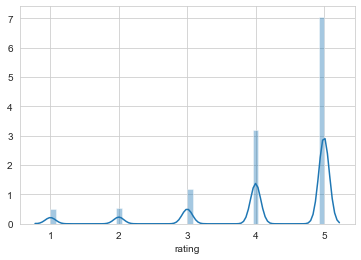

In [56]:
print(df['rating'].value_counts(normalize=True))
sns.distplot(df['rating'])

56.4% of the ratings are 5. Also, the ratings are discrete and not continuous.

# Popularity based recommender system
- We will be recommending the most popular products.<br>
- The "popularity" is described by the total no. of ratings as well as the mean ratings.

**Finding the mean rating and number of ratings of each product in training set:**

In [57]:
#mean rating of each product
df_new = pd.DataFrame(df.groupby("prodid").mean()['rating'])
df_new.rename(columns = {'rating':'mean rating'}, inplace = True)

#no. of ratings of each product
df_new['no. of ratings'] = pd.DataFrame(df.groupby(by="prodid").count()["userid"])

df_new = df_new.reset_index()

In [58]:
df_new

,prodid,mean rating,no. of ratings
0,0594451647,5.000000,1
1,0594481813,3.000000,1
2,0970407998,2.500000,2
3,0972683275,4.750000,4
4,1400501466,3.333333,6
...,...,...,...
48185,B00LED02VY,4.000000,1
48186,B00LGN7Y3G,5.000000,1
48187,B00LGQ6HL8,5.000000,5
48188,B00LI4ZZO8,4.500000,2


**Lets see the distribution of number of ratings:**

count    48190.000000
mean         2.611973
std          5.141867
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        206.000000
Name: no. of ratings, dtype: float64


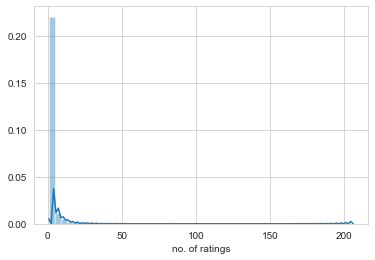

In [59]:
print(df_new["no. of ratings"].describe())
sns.distplot(df_new["no. of ratings"])

- On an average a product has ~2 to ~3 number of ratings.<br>
- 75% of the products have 2 or less than 2 number of ratings (75th percentile).<br>
- Products with the highest number of ratings have 206 ratings.<br>

**Product with highest no. of ratings:**

In [60]:
df_new[df_new["no. of ratings"]==206]

#There is only one product that has 206 ratings

,prodid,mean rating,no. of ratings
39003,B0088CJT4U,4.218447,206


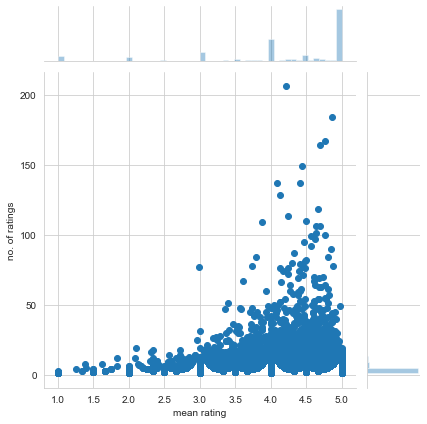

In [61]:
sns.jointplot(x='mean rating', y='no. of ratings', data=df_new)

**Above we can see that usually the products that have higher number of ratings have high mean rating.**

**Looking at the top 30 popularity recommendations for each users:**<br>
We have established that the "popularity" of a product is not just defined by the highest mean rating it got but also by the number of ratings it has. It is highly likely that there is a product having a mean rating of 5 but was rated by just 50 people while there is a product that has a mean rating of 4.5 or 4 but was rated by 150 people. In our opinion, the second product is much more reliable.<br>Therefore to account for the number of ratings as well as the mean ratings we will multiply both of them. The resulting number will serve as a weighted mean.  

In [62]:
df_new["weighted mean"] = df_new["mean rating"] * df_new["no. of ratings"]

In [63]:
df_new

,prodid,mean rating,no. of ratings,weighted mean
0,0594451647,5.000000,1,5.0
1,0594481813,3.000000,1,3.0
2,0970407998,2.500000,2,5.0
3,0972683275,4.750000,4,19.0
4,1400501466,3.333333,6,20.0
...,...,...,...,...
48185,B00LED02VY,4.000000,1,4.0
48186,B00LGN7Y3G,5.000000,1,5.0
48187,B00LGQ6HL8,5.000000,5,25.0
48188,B00LI4ZZO8,4.500000,2,9.0


In [64]:
recommendations = df_new.sort_values(["weighted mean"],ascending=False).head(30)

In [65]:
def recommend_30(user_id):     
    user_recommendations = recommendations
    return user_recommendations 

lets see recommendations for a few users. We will randomly select 3 users and see top 30 recommendations for them:

In [66]:
unique_users = df["userid"].unique().tolist()

#selecting 3 random users
three_users = np.random.randint(low=0, high=1540, size=3)
print("30 popular products for the following 3 users:")
print("")
for i in three_users:
    print("user: "+unique_users[i])
    display(recommend_30(i))
    print("####################################################################")
    print("")

30 popular products for the following 3 users:

user: A1F1A0QQP2XVH5


,prodid,mean rating,no. of ratings,weighted mean
24827,B003ES5ZUU,4.864130,184,895.0
39003,B0088CJT4U,4.218447,206,869.0
11078,B000N99BBC,4.772455,167,797.0
38250,B007WTAJTO,4.701220,164,771.0
38615,B00829TIEK,4.436242,149,661.0
38611,B00829THK0,4.416058,137,605.0
39338,B008DWCRQW,4.094891,137,561.0
28761,B004CLYEDC,4.669492,118,551.0
21982,B002R5AM7C,4.125000,128,528.0
22460,B002V88HFE,4.698113,106,498.0


####################################################################

user: A7QMQBGJ2TCQG


,prodid,mean rating,no. of ratings,weighted mean
24827,B003ES5ZUU,4.864130,184,895.0
39003,B0088CJT4U,4.218447,206,869.0
11078,B000N99BBC,4.772455,167,797.0
38250,B007WTAJTO,4.701220,164,771.0
38615,B00829TIEK,4.436242,149,661.0
38611,B00829THK0,4.416058,137,605.0
39338,B008DWCRQW,4.094891,137,561.0
28761,B004CLYEDC,4.669492,118,551.0
21982,B002R5AM7C,4.125000,128,528.0
22460,B002V88HFE,4.698113,106,498.0


####################################################################

user: A5GPH59NDWJRB


,prodid,mean rating,no. of ratings,weighted mean
24827,B003ES5ZUU,4.864130,184,895.0
39003,B0088CJT4U,4.218447,206,869.0
11078,B000N99BBC,4.772455,167,797.0
38250,B007WTAJTO,4.701220,164,771.0
38615,B00829TIEK,4.436242,149,661.0
38611,B00829THK0,4.416058,137,605.0
39338,B008DWCRQW,4.094891,137,561.0
28761,B004CLYEDC,4.669492,118,551.0
21982,B002R5AM7C,4.125000,128,528.0
22460,B002V88HFE,4.698113,106,498.0


####################################################################



### Remarks:
**We have seen that we have a lot of products that have 5 star rating but still in our top 30 recommendations we barely have a 5 star rating. This is because it makes more sense that a product with 4 star having 70 ratings in total is much more reliable than a product with 5 star rating having just 20 ratings.<br><br>Also, we see that for all the users, we have recommended same products rated in the same order. This is because the recommendations here are based on the popularity of the product and not on the kind of the user. Hence a product popular for user 1 is also popular for user 200. Therefore all the users will have the same recommendations.**

# Collaborative filtering recommender system
- We will build a matrix factorization model which is a class of collaboratrive filtering recommender system that involves user-item interaction.<br>
- We will use the following dataframe. Remember we only took those users who had rated atleast 50 products.<br>
- Deleting timestamp column since we do not need it.<br>

## The Approach:
**We will divide the dataset into train and test set. Following which we will predict user-product rating in test set user-item matrix based on the SVD matrix reconsructed from train set user-item matrix. Since we are splitting in the train and test sets, there will be user-item pairs that will have the "actual rating" in the test set matrix but the same user-item pair will be depicted by NaN in the train set matrix. Also, due to train test split, there might be products and users that are present in train set and not in test set. Therefore we will not predict for them as we see these user-item pairs in the test set as "new" users and "new" products. Hence, they are a part of "cold start" problem and collaborative filtering is not the correct approach for such user item pairs.**<br>
Having said that we will find **rmse** for **train set matrix & svd reconstructed matrix(which will be rmse on train set)** and **test set matrix & svd reconstructed matrix(which will be rmse on test set).**

In [67]:
df = df.drop("timestamp",axis=1)
print(df.shape)
df.head()

(125871, 3)


,userid,prodid,rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


**splitting the data into training and testing set in 85:15 ratio:**

In [42]:
train_data, test_data = train_test_split(df, test_size = 0.15, random_state=7)
print("shape of training set: "+str(train_data.shape))
print("shape of testing set: "+str(test_data.shape))

shape of training set: (106990, 3)
shape of testing set: (18881, 3)


**Making pivot table (utility matrix) on the training set:**

In [43]:
train_mat = train_data.pivot(index='userid', columns='prodid', values='rating')
train_mat

prodid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8
userid,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A105S56ODHGJEK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A105TOJ6LTVMBG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10AFVU66A79Y1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZBXKUH4AIW3X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZCE11PSTCH1L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZMY6E8B52L2T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


we can see a lot of NaN values in the cell. These cells represent users-item pairs where the user has not given ratings to the product. Lets see the sparsity of the matrix. **If the sparsity of the matrix is too high, then matrix factorization would be a better choice for collaborative filtering as compared to other filtering methods.**<br>For the matrix to be sparse, count of nan elements in the matrix must be greater than (size of the matrix)/2.

In [44]:
if(sum(train_mat.isnull().sum().values) > (train_mat.shape[0]*train_mat.shape[1])/2):
    print("matrix is sparse! i.e a lot of NaN values")
else:
    print("matrix is suitable for collaborative filtering!")

matrix is sparse! i.e a lot of NaN values


We will fill in the NaN values by 0. Now 0's represent user-item pairs where there are no ratings for the item provided by the user.

In [45]:
train_mat = train_mat.fillna(0)
train_mat

prodid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8
userid,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZBXKUH4AIW3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZCE11PSTCH1L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZMY6E8B52L2T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Making a function to find the predicted user-item matrix using SVD. This function takes the training matrix and number of latent features. Default number of latent features is 10. Second function is to find the RMSE(Root Mean Squared errror) and MAE(Mean Absolute Error) between average actual rating of the products and average predicted rating of the products.**

In [25]:
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_absolute_error

def predicted_matrix(matrix,latent_features=10):
    U, sigma, Vt = svds(matrix, k = latent_features) #choosing k latent attributes, default is 10
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
    predictions = pd.DataFrame(all_user_predicted_ratings, columns = matrix.columns, index=matrix.index)
    return predictions


def rmse_mae(matrix,predicted_matrix):
    rmse = round((((matrix.mean() - predicted_matrix.mean()) ** 2).mean() ** 0.5), 5)
    mae = round((abs(matrix.mean() - predicted_matrix.mean())).mean(),5)
    return rmse,mae

We will find the predicted matrix after matrix factorization for k=10 i.e 10 latent features.

In [26]:
pred_mat = predicted_matrix(train_mat,10)
pred_mat

prodid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8
userid,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.002168,0.004046,0.004536,0.007669,0.003925,0.002959,0.005241,-0.000129,0.010738,0.002588,...,-0.004308,0.000506,0.011376,0.002137,0.067659,-0.001888,0.007819,0.001273,0.098602,0.022525
A100WO06OQR8BQ,0.000343,0.000152,0.004581,0.014490,0.006575,0.000186,0.012455,0.001719,-0.004778,0.000150,...,0.026812,0.000211,0.007847,-0.000158,-0.002789,0.002794,-0.001321,0.002587,-0.031476,0.007472
A105S56ODHGJEK,-0.000756,-0.001406,0.001090,0.022008,0.006311,-0.001195,0.004826,0.004379,0.000800,-0.000642,...,0.017256,-0.000275,0.010755,-0.000863,-0.028708,0.028293,-0.003250,0.000949,0.001688,0.002673
A105TOJ6LTVMBG,0.002467,0.003829,0.002102,0.009735,0.004537,0.002757,0.004312,-0.000086,0.007303,0.002378,...,-0.004595,0.000477,-0.000653,0.001506,-0.003370,-0.001056,0.000011,0.002484,-0.003286,-0.003820
A10AFVU66A79Y1,0.000947,0.000793,0.002373,0.013684,0.005245,0.000866,0.006566,0.001491,-0.001670,0.000868,...,0.012690,0.000070,0.005451,0.000006,-0.027987,0.008931,-0.002520,0.001942,-0.030313,0.003369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZBXKUH4AIW3X,0.001459,0.002313,0.001443,0.006003,0.002502,0.001607,0.002501,-0.000138,0.003695,0.001378,...,-0.002718,0.000285,0.000519,0.000910,0.001795,-0.000673,0.000368,0.001540,0.002661,-0.001612
AZCE11PSTCH1L,0.001383,0.002716,0.001571,0.007737,0.002765,0.001894,0.002556,0.000017,0.004581,0.001635,...,-0.004309,0.000312,0.001021,0.000886,0.005238,0.000254,0.000696,0.001936,0.007884,-0.001994
AZMY6E8B52L2T,0.001958,0.003479,0.011014,-0.017215,-0.006356,0.002293,0.000576,-0.004835,0.008867,0.001762,...,-0.002933,0.000431,0.045962,0.003511,0.277488,-0.022154,0.031536,-0.003730,0.369737,0.103270


In [27]:
rmse,mae = rmse_mae(train_mat,pred_mat)
print("rmse of predicted matrix and train matrix: "+str(rmse))
print("mae of predicted matrix and train matrix: "+str(mae))

rmse of predicted matrix and train matrix: 0.00332
mae of predicted matrix and train matrix: 0.00227


**Lets find the rmse and mae on testing set. Making pivot table (utility matrix) on the testing set:**

In [28]:
test_mat = test_data.pivot(index='userid', columns='prodid', values='rating').fillna(0)
test_mat

prodid,1400532655,1400599997,9573212919,9800359788,9983891212,9984922626,B000000O48,B000001OM5,B000001ON6,B00000DM9W,...,B00KXUHX9S,B00L0YFJHY,B00L21HC7A,B00L2442H0,B00L2P3TRS,B00L3YHF6O,B00L8I6SFY,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userid,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZBXKUH4AIW3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZCE11PSTCH1L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZMY6E8B52L2T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0


As we have said that there might be certain user and products in the test set that are not present in train set. We will incorporate only the common user-item pairs from both the test and train sets.

In [29]:
def rmse_mae_testset(matrix,predicted_matrix):
    
    #no. of users present in test set but not in train set
    users_only_in_test = len(set(matrix.index) - set(predicted_matrix.index))
    if(users_only_in_test>0):
        print(str(users_only_in_test)+" number of users are present in test set but not in train set.")
        print("")
    else:
        print("All users that are present in test set are also present in train set.")
        print("")
        
    
    #no. of products present in test set but not in train set
    prod_only_in_test = len(set(matrix.columns) - set(predicted_matrix.columns))
    if(prod_only_in_test>0):
        print(str(prod_only_in_test)+" number of products are present in test set but not in train set. We will not predict for these products as they represent 'new' products. Hence they are a part of cold start problem.")
        print("")
    else:
        print("All products that are present in test set are also present in train set.")
        print("")
        
    
    #finding common products in both train and test set
    common_prods = set.intersection(set(matrix.columns),set(predicted_matrix.columns))
    print(str(len(common_prods))+" products are common in both train and test sets. We will predict for these products.")
    print("")
    
    
    #finding common product's mean ratings from test matrix and predicted matrix
    prod_means_pred = list()
    prod_means_test = list()
    
    for product in common_prods:
        prod_means_pred.append(predicted_matrix[product].mean()) #mean rating of these products in svd reconstructed matix
        prod_means_test.append(matrix[product].mean()) #mean rating of these products in test set
        
   #converting them to series 
    product_predicted_mean = pd.Series(data=prod_means_pred, index=list(common_prods))
    product_test_mean = pd.Series(data=prod_means_test, index=list(common_prods))
    rmse = round((((product_test_mean - product_predicted_mean) ** 2).mean() ** 0.5), 5)
    mae = round((abs(product_test_mean - product_predicted_mean)).mean(),5)
    
    #saving results in a dataframe
    test_preds = pd.DataFrame({"products":list(common_prods),"mean rating in test set":product_test_mean,"mean predicted rating in svd matrix":product_predicted_mean}).reset_index(drop=True)
    
    return rmse,mae,test_preds


In [30]:
rmse_t,mae_t,test_preds = rmse_mae_testset(test_mat,pred_mat)
print("rmse of predicted matrix and test matrix: "+str(rmse_t))
print("mae of predicted matrix and test matrix: "+str(mae_t))

All users that are present in test set are also present in train set.

4796 number of products are present in test set but not in train set. We will not predict for these products as they represent 'new' products. Hence they are a part of cold start problem.

8006 products are common in both train and test sets. We will predict for these products.

rmse of predicted matrix and test matrix: 0.02618
mae of predicted matrix and test matrix: 0.01238


In [31]:
test_preds

,products,mean rating in test set,mean predicted rating in svd matrix
0,B004BI6MVS,0.002597,0.003781
1,B004M8ST5O,0.001948,0.012945
2,B001D2CW1E,0.003247,0.007182
3,B00F19PYR4,0.003247,0.007752
4,B004E10KFG,0.020130,0.049981
...,...,...,...
8001,B0012Y6VQA,0.000649,0.003990
8002,B001CK9760,0.002597,0.019857
8003,B000SDLNKA,0.002597,0.007502
8004,B002KKCNHG,0.003247,0.002152


### Therefore, we can see that RMSE and MAE b/w training utility matrix and svd reconstructed matrix (k=10) is 0.0033 and 0.0022 respectively. While RMSE and MAE b/w testing utility matrix and same svd reconstructed matrix is 0.026 and 0.012 respectively.<br>
## Further we will try to improve the RMSE and MAE by dealing with rating bias. 
**Rating bias occurs because sometimes the people are too sympathetic or generous while giving ratings, At the same time there are people who are very critical while giving the ratings. Therefore we need to estimate a fair rating for each product and user pair in both test and train sets. This will be done by subtracting rating bias from the actual ratings.**<br><br>*Rating bias  =  Global avg. rating  -  user bias  -  item bias*<br><br>**global avg. rating (GR): avg rating of all items<br>user bias: avg rating of ith user minus GR<br>item bias: avg rating of ith item minus GR**<br><br>Lets find these three components:<br><br>**Global Average Rating**

In [32]:
global_mean_rating_train = train_data["rating"].mean()
global_mean_rating_train

4.2628096083746145

In [33]:
global_mean_rating_test = test_data["rating"].mean()
global_mean_rating_test

4.253005667072719

**User Bias: Mean rating by ith user - Global Average Rating**<br>
**Item Bias: Mean rating of ith item - Global Average Rating**

In [34]:
user_biases_train = train_data.groupby("userid").mean()["rating"] - global_mean_rating_train
user_biases_train = user_biases_train.to_dict()

prod_biases_train = train_data.groupby("prodid").mean()["rating"] - global_mean_rating_train
prod_biases_train = prod_biases_train.to_dict()

In [35]:
user_biases_test = test_data.groupby("userid").mean()["rating"] - global_mean_rating_test
user_biases_test = user_biases_test.to_dict()

prod_biases_test = test_data.groupby("prodid").mean()["rating"] - global_mean_rating_test
prod_biases_test = prod_biases_test.to_dict()

In [36]:
train_data["user bias"] = train_data["userid"].replace(user_biases_train)
train_data["product bias"] = train_data["prodid"].replace(prod_biases_train)
train_data["rating bias"] = global_mean_rating_train - train_data["user bias"] - train_data["product bias"]

test_data["user bias"] = test_data["userid"].replace(user_biases_test)
test_data["product bias"] = test_data["prodid"].replace(prod_biases_test)
test_data["rating bias"] = global_mean_rating_test - test_data["user bias"] - test_data["product bias"]

**Calculating the corrected rating after removing the bias:**

In [37]:
train_data["corrected rating"] = train_data["rating"] - train_data["rating bias"]
test_data["corrected rating"] = test_data["rating"] - test_data["rating bias"]

**New training and testing set:**

In [38]:
train_data.head(7)

,userid,prodid,rating,user bias,product bias,rating bias,corrected rating
6350379,A1MZL91Z44RN06,B008R7EWF2,4.0,0.289571,0.070524,3.902715,0.097285
4024281,A9Y5O2R4D6EH5,B004CLYEB4,4.0,-0.239000,0.237190,4.264619,-0.264619
5584433,ATS2855497V0I,B00746LVOM,5.0,-0.409151,0.171973,4.499988,0.500012
500763,A25HBO5V8S8SEA,B0002PC8EO,5.0,0.715914,0.737190,2.809705,2.190295
238093,A28J3123I1QDKI,B000083KIH,5.0,-0.241533,0.112190,4.392152,0.607848
611449,A16RI68PS6T5CA,B0007QS608,5.0,-0.277961,0.737190,3.803580,1.196420
4000931,A3NOBH42C7UI5M,B004BDOREC,4.0,-0.489000,-0.512810,5.264619,-1.264619


In [39]:
test_data.head(7)

,userid,prodid,rating,user bias,product bias,rating bias,corrected rating
1106621,A1RPTVW5VEOSI,B000K5VD2E,1.0,-0.169672,-3.253006,7.675684,-6.675684
7577499,A213J54E63SYOP,B00EYVNFMG,4.0,-0.443482,-0.253006,4.949493,-0.949493
3628707,A17V9XL4CWTQ6G,B003W5QCTI,4.0,0.318423,-0.253006,4.187588,-0.187588
2709001,A3V7D0LH8L7BG0,B002MAPS6W,4.0,0.126305,-0.253006,4.379707,-0.379707
1700241,ATNOI7E8GTIVE,B0015A8Y3E,5.0,0.656085,0.746994,2.849926,2.150074
261658,A3VL4RXCWNSR3H,B00008Y1BX,3.0,0.175566,-1.253006,5.330446,-2.330446
2213432,A2ROZACRW31PC2,B001P9XHHI,4.0,-0.453006,0.246994,4.459017,-0.459017


**Again making test and train utility matrices but this time with corrected ratings**

In [40]:
train_mat_2 = train_data.pivot(index='userid', columns='prodid', values='corrected rating').fillna(0)
test_mat_2 = test_data.pivot(index='userid', columns='prodid', values='corrected rating').fillna(0)

**SVD predicted matrix on training utility matrix**

In [41]:
pred_mat_2 = predicted_matrix(train_mat_2,10)
pred_mat_2

prodid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8
userid,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,1.112539e-05,-0.000243,-0.001136,0.000684,-0.000799,4.133537e-05,-7.414757e-05,0.006461,-0.000386,-0.000351,...,0.000846,-0.000001,0.001317,-1.199809e-05,-3.954454e-05,-0.000973,-4.118461e-05,0.000107,0.005774,-0.000414
A100WO06OQR8BQ,4.859021e-05,-0.001016,-0.005391,0.002720,-0.004023,1.777433e-04,-3.556246e-04,-0.006014,0.007952,-0.001671,...,0.004310,-0.000059,0.006191,1.374273e-04,-1.580017e-04,-0.003868,-1.580592e-04,0.000430,0.022416,-0.001767
A105S56ODHGJEK,3.381921e-05,-0.000705,-0.003662,0.001914,-0.002676,1.240248e-04,-2.399254e-04,0.000956,-0.001523,-0.001165,...,0.002948,-0.000034,0.004201,6.530916e-05,-1.124664e-04,-0.002754,-1.129082e-04,0.000304,0.015969,-0.001236
A105TOJ6LTVMBG,1.224637e-06,-0.000034,-0.000134,0.000069,-0.000096,4.196377e-06,-8.965140e-06,-0.000205,0.000160,-0.000116,...,0.000107,-0.000001,0.000151,2.240548e-06,-4.261156e-06,-0.000099,-4.068757e-06,0.000012,0.000573,-0.000044
A10AFVU66A79Y1,1.135824e-05,-0.000237,-0.001223,0.000654,-0.000886,4.167950e-05,-8.022378e-05,0.000670,0.000729,-0.000378,...,0.000963,-0.000009,0.001403,2.010091e-05,-3.804797e-05,-0.000924,-3.809289e-05,0.000102,0.005382,-0.000413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZBXKUH4AIW3X,1.693144e-06,-0.000036,-0.000180,0.000100,-0.000133,6.235939e-06,-1.182679e-05,0.000214,0.000265,-0.000053,...,0.000139,-0.000001,0.000208,2.331451e-06,-5.793041e-06,-0.000140,-5.780737e-06,0.000015,0.000818,-0.000062
AZCE11PSTCH1L,-1.295212e-07,0.000003,0.000013,-0.000007,0.000023,-4.779743e-07,8.822755e-07,-0.000094,-0.000038,0.000003,...,-0.000011,0.000001,-0.000020,-5.683464e-09,3.719165e-07,0.000012,4.896357e-07,-0.000001,-0.000072,0.000005
AZMY6E8B52L2T,4.488490e-05,-0.000952,-0.004771,0.002655,-0.003513,1.655471e-04,-3.137592e-04,0.005772,0.004638,-0.001385,...,0.003710,-0.000034,0.005525,6.050145e-05,-1.539090e-04,-0.003719,-1.537561e-04,0.000413,0.021756,-0.001640


training errors:

In [42]:
rmse,mae = rmse_mae(train_mat_2,pred_mat_2)
print("rmse of predicted matrix and train matrix: "+str(rmse))
print("mae of predicted matrix and train matrix: "+str(mae))

rmse of predicted matrix and train matrix: 0.00241
mae of predicted matrix and train matrix: 0.00145


testing errors:

In [43]:
rmse_t,mae_t,test_preds = rmse_mae_testset(test_mat_2,pred_mat_2)
print("rmse of predicted matrix and test matrix: "+str(rmse_t))
print("mae of predicted matrix and test matrix: "+str(mae_t))

All users that are present in test set are also present in train set.

4796 number of products are present in test set but not in train set. We will not predict for these products as they represent 'new' products. Hence they are a part of cold start problem.

8006 products are common in both train and test sets. We will predict for these products.

rmse of predicted matrix and test matrix: 0.00441
mae of predicted matrix and test matrix: 0.00238


In [44]:
test_preds

,products,mean rating in test set,mean predicted rating in svd matrix
0,B004BI6MVS,-0.000493,-0.000057
1,B004M8ST5O,-0.001521,0.000009
2,B001D2CW1E,0.001396,0.000169
3,B00F19PYR4,0.000871,0.000094
4,B004E10KFG,-0.003017,0.001203
...,...,...,...
8001,B0012Y6VQA,-0.004970,-0.001871
8002,B001CK9760,-0.000151,0.000595
8003,B000SDLNKA,-0.000574,-0.000088
8004,B002KKCNHG,0.001079,-0.000354


# We can see an improvement after estimating the fair ratings. 
### Earlier:
**training rmse and mae:** 0.0033 and 0.0022<br>**testing rmse and mae:** 0.026 and 0.012
### After rating correction:
**training rmse and mae:** 0.0024 and 0.0014<br>**testing rmse and mae:** 0.004 and 0.002

# Lets predict top 5 recommendations for the users. We will enter the user id and get its top 5 recommendations from the items it has not already rated.
This is our predicted matrix (after rating correction):

In [45]:
pred_mat_2

prodid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8
userid,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,1.112539e-05,-0.000243,-0.001136,0.000684,-0.000799,4.133537e-05,-7.414757e-05,0.006461,-0.000386,-0.000351,...,0.000846,-0.000001,0.001317,-1.199809e-05,-3.954454e-05,-0.000973,-4.118461e-05,0.000107,0.005774,-0.000414
A100WO06OQR8BQ,4.859021e-05,-0.001016,-0.005391,0.002720,-0.004023,1.777433e-04,-3.556246e-04,-0.006014,0.007952,-0.001671,...,0.004310,-0.000059,0.006191,1.374273e-04,-1.580017e-04,-0.003868,-1.580592e-04,0.000430,0.022416,-0.001767
A105S56ODHGJEK,3.381921e-05,-0.000705,-0.003662,0.001914,-0.002676,1.240248e-04,-2.399254e-04,0.000956,-0.001523,-0.001165,...,0.002948,-0.000034,0.004201,6.530916e-05,-1.124664e-04,-0.002754,-1.129082e-04,0.000304,0.015969,-0.001236
A105TOJ6LTVMBG,1.224637e-06,-0.000034,-0.000134,0.000069,-0.000096,4.196377e-06,-8.965140e-06,-0.000205,0.000160,-0.000116,...,0.000107,-0.000001,0.000151,2.240548e-06,-4.261156e-06,-0.000099,-4.068757e-06,0.000012,0.000573,-0.000044
A10AFVU66A79Y1,1.135824e-05,-0.000237,-0.001223,0.000654,-0.000886,4.167950e-05,-8.022378e-05,0.000670,0.000729,-0.000378,...,0.000963,-0.000009,0.001403,2.010091e-05,-3.804797e-05,-0.000924,-3.809289e-05,0.000102,0.005382,-0.000413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZBXKUH4AIW3X,1.693144e-06,-0.000036,-0.000180,0.000100,-0.000133,6.235939e-06,-1.182679e-05,0.000214,0.000265,-0.000053,...,0.000139,-0.000001,0.000208,2.331451e-06,-5.793041e-06,-0.000140,-5.780737e-06,0.000015,0.000818,-0.000062
AZCE11PSTCH1L,-1.295212e-07,0.000003,0.000013,-0.000007,0.000023,-4.779743e-07,8.822755e-07,-0.000094,-0.000038,0.000003,...,-0.000011,0.000001,-0.000020,-5.683464e-09,3.719165e-07,0.000012,4.896357e-07,-0.000001,-0.000072,0.000005
AZMY6E8B52L2T,4.488490e-05,-0.000952,-0.004771,0.002655,-0.003513,1.655471e-04,-3.137592e-04,0.005772,0.004638,-0.001385,...,0.003710,-0.000034,0.005525,6.050145e-05,-1.539090e-04,-0.003719,-1.537561e-04,0.000413,0.021756,-0.001640


In [66]:
def give_top_k_recommendations(user,k=5):
    
    sorted_user_predictions = pred_mat_2.loc[user].sort_values(ascending=False)
    sorted_user_predictions = pd.DataFrame(sorted_user_predictions).reset_index()
    sorted_user_predictions.rename(columns = {user: 'predictions'},inplace=True)
    
    #All products rated by this user
    products_rated = train_data[train_data["userid"] == user]
    if(len(products_rated)>0):
        print(user+" has already rated "+str(len(products_rated))+" product(s) out of total "+str(len(train_data.groupby("prodid").sum()))+" products")
    else:
        print(user+" has not rated any products")
    
    #products not rated by the user
    products_not_rated = train_data[~train_data['prodid'].isin(products_rated['prodid'])]
    products_not_rated = products_not_rated.groupby("prodid").count().reset_index()
    print("Below are the top "+str(k)+" recommendations from the remaining "+str(len(products_not_rated))+" products:")
    
    print("")
    
    recommend_df = products_not_rated.merge(sorted_user_predictions, how="left", left_on='prodid', right_on='prodid')
    return recommend_df.sort_values('predictions', ascending = False)[["prodid","predictions"]].head(k)
    

**This function takes a user id and the number of recommendations you want to see. By default it will give top 5 recommendations.**

In [67]:
recommendations = give_top_k_recommendations("A100UD67AHFODS")
recommendations

A100UD67AHFODS has already rated 97 product(s) out of total 43394 products
Below are the top 5 recommendations from the remaining 43297 products:



,prodid,predictions
22332,B003ES5ZUU,0.061675
34369,B007WTAJTO,0.034070
8296,B000G810Q4,0.033943
32009,B006B1CF1O,0.033943
1801,B00006HQID,0.033943


**lets see recommendations for a few users. We will randomly select 5 users and give top 10 recommendations for them.**

In [68]:
unique_users = df["userid"].unique().tolist()

#selecting 5 random users
five_users = np.random.randint(low=0, high=1540, size=5)
print("top 10 recommendations for the following 5 users:")
print("")
for i in five_users:
    print("user: "+unique_users[i])
    display(give_top_k_recommendations(unique_users[i],10))
    print("####################################################################")
    print("")

top 10 recommendations for the following 5 users:

user: A21INUA35HX4XQ
A21INUA35HX4XQ has already rated 74 product(s) out of total 43394 products
Below are the top 10 recommendations from the remaining 43320 products:



,prodid,predictions
22330,B003ES5ZUU,0.005094
25865,B004CLYEDC,0.002320
34370,B007WTAJTO,0.002317
34704,B0082E9K7U,0.002209
25867,B004CLYEFK,0.002103
9955,B000N99BBC,0.002081
13956,B0019EHU8G,0.002068
41854,B00G4UQ6U8,0.001972
11686,B000VX6XL6,0.001878
34732,B00834SJSK,0.001723


####################################################################

user: A2ZWJVKITA32OV
A2ZWJVKITA32OV has already rated 41 product(s) out of total 43394 products
Below are the top 10 recommendations from the remaining 43353 products:



,prodid,predictions
22344,B003ES5ZUU,0.022899
2526,B00008WM9J,0.021316
4859,B0002Q2NW0,0.020543
6388,B0009WIP1U,0.020543
8381,B000GHSAWM,0.020543
32082,B006CQR7CK,0.020543
10120,B000NTK7ZG,0.020543
10069,B000NNFS4C,0.020543
5596,B0007L7E4M,0.020543
4552,B0002ER3BS,0.020543


####################################################################

user: A2MCRCK1V61FWQ
A2MCRCK1V61FWQ has already rated 50 product(s) out of total 43394 products
Below are the top 10 recommendations from the remaining 43344 products:



,prodid,predictions
22333,B003ES5ZUU,0.006324
34393,B007WTAJTO,0.003415
34728,B0082E9K7U,0.002947
25869,B004CLYEDC,0.002903
34755,B00834SJNA,0.002687
41878,B00G4UQ6U8,0.002669
13954,B0019EHU8G,0.002666
25871,B004CLYEFK,0.002581
9946,B000N99BBC,0.002545
11679,B000VX6XL6,0.002360


####################################################################

user: AJL3U764D7NI3
AJL3U764D7NI3 has already rated 56 product(s) out of total 43394 products
Below are the top 10 recommendations from the remaining 43338 products:



,prodid,predictions
22344,B003ES5ZUU,0.020247
34394,B007WTAJTO,0.010541
34728,B0082E9K7U,0.009336
25879,B004CLYEDC,0.009300
13969,B0019EHU8G,0.008499
41873,B00G4UQ6U8,0.008441
9960,B000N99BBC,0.008274
25881,B004CLYEFK,0.008260
11693,B000VX6XL6,0.007549
34755,B00834SJNA,0.007308


####################################################################

user: A1X2LENOF84LCQ
A1X2LENOF84LCQ has already rated 69 product(s) out of total 43394 products
Below are the top 10 recommendations from the remaining 43325 products:



,prodid,predictions
22323,B003ES5ZUU,0.389527
34379,B007WTAJTO,0.191963
25859,B004CLYEDC,0.178615
34713,B0082E9K7U,0.174502
13951,B0019EHU8G,0.161549
9947,B000N99BBC,0.161505
25861,B004CLYEFK,0.160120
41861,B00G4UQ6U8,0.156878
11677,B000VX6XL6,0.144394
39160,B00BOHNYTW,0.132518


####################################################################

